<a href="https://colab.research.google.com/github/kenny08gt/proyecto_statistical_learning2/blob/master/ProyectoSL2_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch
import math

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

# device = 'cuda' if torch.cuda.is_available() else 'cpu'

device = 'cpu'

data = pd.read_csv('/content/drive/My Drive/statistical learning 2/Proyecto/pmsm_temperature_data.csv')
data.describe()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
count,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000
mean,-0.003905,0.004723,0.004780,-0.005690,-0.006336,-0.003333,0.006043,-0.003194,-0.004396,0.000609,-0.002208,-0.003935,50.732001
std,0.993127,1.002423,0.997878,1.002330,1.001229,0.997907,0.998994,0.997912,0.995686,1.001049,0.999597,0.998343,22.073125
min,-8.573954,-1.429349,-1.655373,-1.861463,-1.371529,-3.345953,-3.245874,-3.341639,-2.631991,-1.834688,-2.066143,-2.019973,4.000000
25%,-0.599385,-1.037925,-0.826359,-0.927390,-0.951892,-0.266917,-0.756296,-0.257269,-0.672308,-0.747265,-0.761951,-0.725622,32.000000
50%,0.266157,-0.177187,0.267542,-0.099818,-0.140246,-0.187246,0.213935,-0.190076,0.094367,-0.057226,0.005085,0.006536,56.000000
75%,0.686675,0.650709,0.358491,0.852625,0.853584,0.547171,1.013975,0.499260,0.680691,0.697344,0.772239,0.725660,68.000000
max,2.967117,2.649032,2.274734,1.793498,2.024164,3.016971,1.060937,2.914185,2.917456,2.449158,2.326668,2.653781,81.000000


* **ambient**: Ambient temperature as measured by a thermal sensor located closely to the stator.
* **coolant**: Coolant temperature. The motor is water cooled. Measurement is taken at outflow.
* **u_d**: Voltage d-component
* **u_q**: Voltage q-component
* **motor_speed**: Motor speed
* **torque**: Torque induced by current.
* **i_d**: Current d-component
* **i_q**: Current q-component
* **pm**: Permanent Magnet surface temperature representing the rotor temperature. This was measured with an infrared thermography unit.
* **stator_yoke**: Stator yoke temperature measured with a thermal sensor.
* **stator_tooth**: Stator tooth temperature measured with a thermal sensor.
* **stator_winding**: Stator winding temperature measured with a thermal sensor.
* **profile_id**:  Each measurement session has a unique ID. Make sure not to try to estimate from one session onto the other as they are strongly independent.

In [0]:
nans=pd.isnull(data).sum()
nans[nans>0]

Series([], dtype: int64)

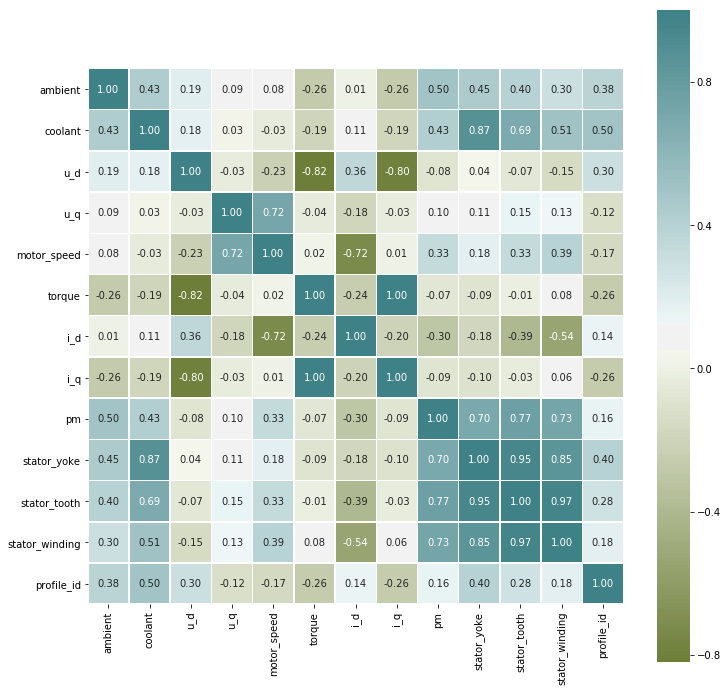

In [0]:
#correlation map
f,ax=plt.subplots(figsize=(12,12))
corr=data.corr()

sns.heatmap(corr, annot=True, linewidths=.5, fmt='.2f', mask= np.zeros_like(corr,dtype=np.bool), cmap=sns.diverging_palette(100,200,as_cmap=True), 
            square=True, ax=ax)

plt.show()

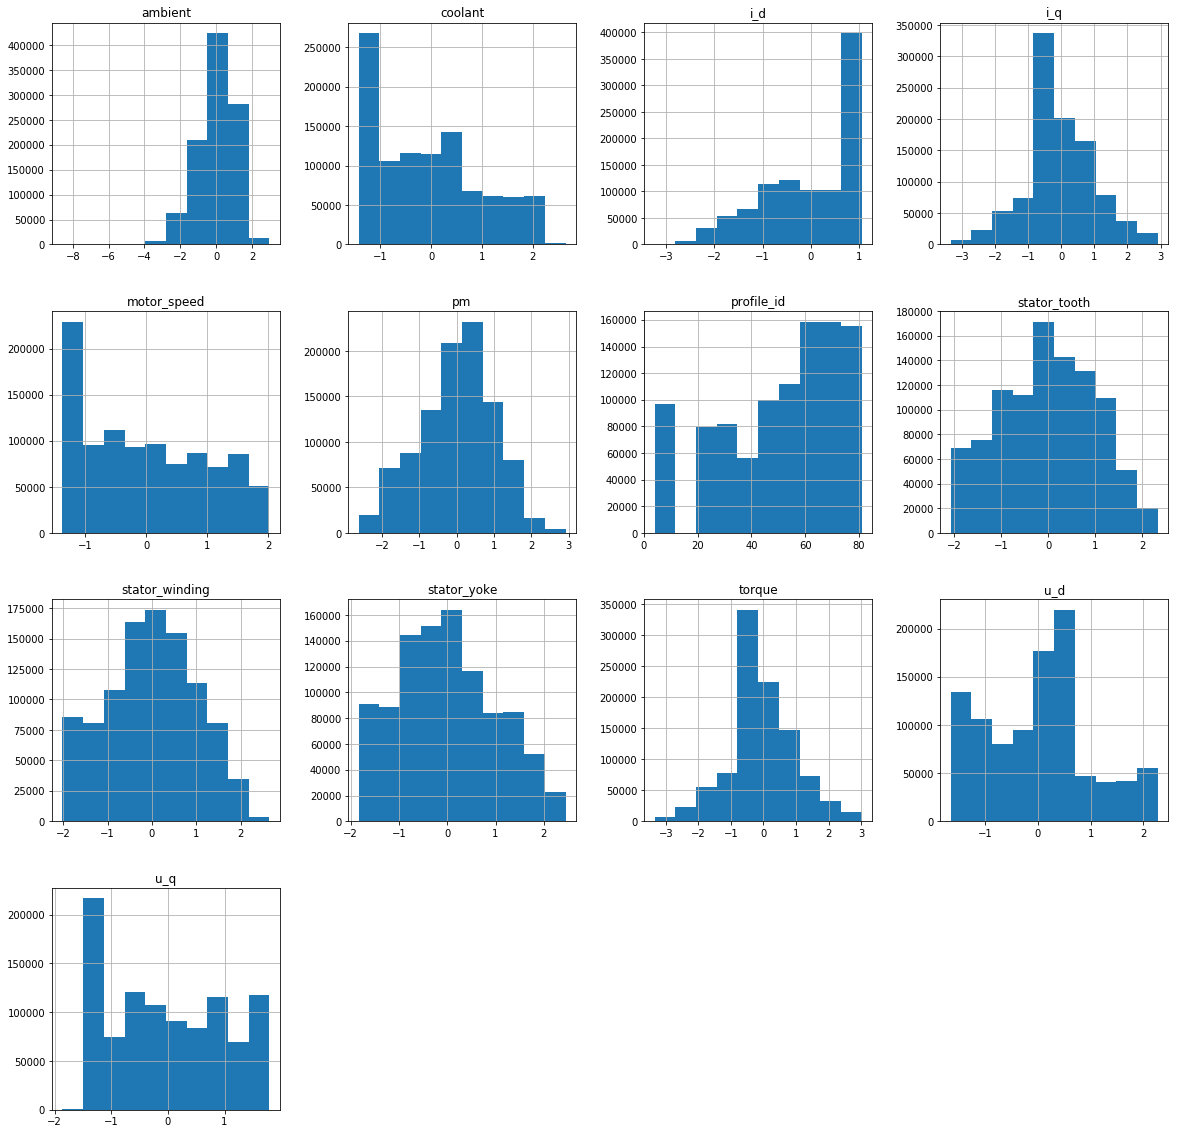

In [0]:
data.hist(figsize = (20,20))
plt.show()

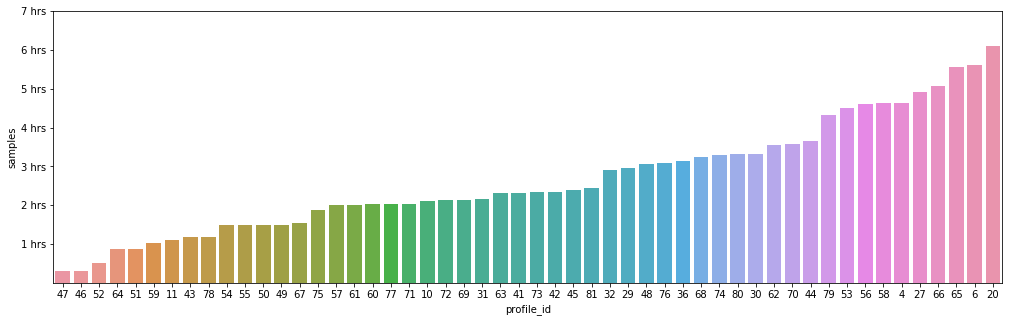

In [0]:
fig = plt.figure(figsize=(17, 5))
grpd = data.groupby(['profile_id'])
_df = grpd.size().sort_values().rename('samples').reset_index()
ordered_ids = _df.profile_id.values.tolist()
sns.barplot(y='samples', x='profile_id', data=_df, order=ordered_ids)
tcks = plt.yticks(2*3600*np.arange(1, 8), [f'{a} hrs' for a in range(1, 8)]) # 2Hz sample rate

In [0]:
data = data.drop(columns=['profile_id'])
data.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145


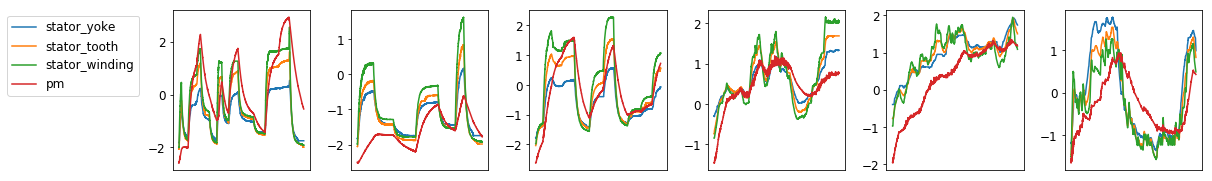

In [0]:
def pick_equidistant_elems(m, n):
    """From a set of n elements, pick m which have equal distance to each other"""
    return [i*n//m + n//(2*m) for i in range(m)]

  
target_features = ['stator_yoke','stator_tooth', 'stator_winding', 'pm']
matplotlib.rcParams.update({'font.size': 12})
ids_to_plot = np.asarray(ordered_ids)[pick_equidistant_elems(6, len(ordered_ids))]
fig2 = plt.figure(figsize=(17, 10))
cols = len(ids_to_plot)
for i, (sess_id, _df) in enumerate([g for g in grpd if g[0] in ids_to_plot]):
    _df = _df.reset_index(drop=True)
    plt.subplot(4, cols, i+1)
    plt.xticks([])
    for target in target_features:
        plt.plot(_df[target], label=target)
    if i == 0:
        plt.legend(loc='upper right', bbox_to_anchor=(-0.2, 1.0))
    
plt.tight_layout()

Unificar variables que representan lo mismo, de acuerdo a los detalles del dataset.

In [0]:
temp = data[['pm','stator_yoke','stator_tooth','stator_winding']]
torque = data[['torque','i_q','u_d']]
everything_else = data[['ambient','coolant','u_q','motor_speed','i_d']]

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca_temp = pca.fit_transform(temp)
temp_df = pd.DataFrame(data = pca_temp, columns = ['temp_1'])

pca = PCA(n_components=1)
pca_torque = pca.fit_transform(torque)
torque_df = pd.DataFrame(data = pca_torque, columns = ['torque_1'])

temporal = pd.concat([temp_df, torque_df], axis = 1)
temporal.head()

final=pd.concat([temporal, everything_else], axis=1)
final.describe()

,temp_1,torque_1,ambient,coolant,u_q,motor_speed,i_d
count,9.980700e+05,9.980700e+05,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000
mean,-4.371408e-15,-7.844740e-15,-0.003905,0.004723,-0.005690,-0.006336,0.006043
std,1.865128e+00,1.653672e+00,0.993127,1.002423,1.002330,1.001229,0.998994
min,-4.212039e+00,-4.273946e+00,-8.573954,-1.429349,-1.861463,-1.371529,-3.245874
25%,-1.318927e+00,-1.228369e+00,-0.599385,-1.037925,-0.927390,-0.951892,-0.756296
50%,3.111943e-02,3.118333e-01,0.266157,-0.177187,-0.099818,-0.140246,0.213935
75%,1.406493e+00,4.873743e-01,0.686675,0.650709,0.852625,0.853584,1.013975
max,4.360209e+00,5.060004e+00,2.967117,2.649032,1.793498,2.024164,1.060937


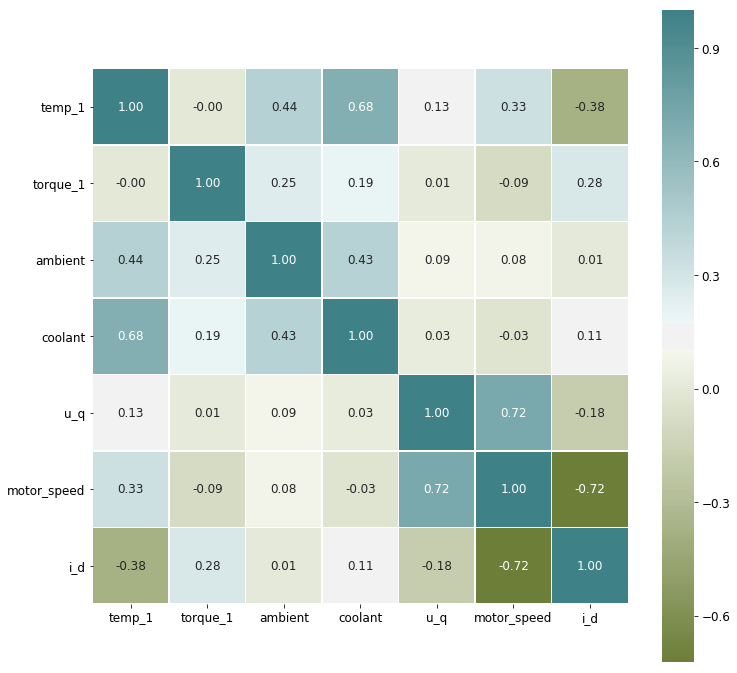

In [0]:
f,ax=plt.subplots(figsize=(12,12))
corr=final.corr()

sns.heatmap(corr, annot=True, linewidths=.5, fmt='.2f', mask= np.zeros_like(corr,dtype=np.bool), cmap=sns.diverging_palette(100,200,as_cmap=True), 
            square=True, ax=ax)

plt.show()

In [0]:
df_x = final.drop(["temp_1", "torque_1", "u_q"],axis=1)
df_y = pd.DataFrame(final['temp_1']) #temp1 is dependent variable.
df_x.head()

,ambient,coolant,motor_speed,i_d
0,-0.752143,-1.118446,-1.222428,1.029572
1,-0.771263,-1.117021,-1.222429,1.029509
2,-0.782892,-1.116681,-1.222428,1.029448
3,-0.780935,-1.116764,-1.222430,1.032845
4,-0.774043,-1.116775,-1.222429,1.031807


In [0]:
df_y.head()

,temp_1
0,-4.183849
1,-4.182892
2,-4.182157
3,-4.181306
4,-4.181587


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

torch.cuda.empty_cache()
torch.cuda.reset_max_memory_cached

xTrain, xTest, yTrain, yTest = train_test_split(df_x.to_numpy(), df_y.to_numpy(), test_size = 0.3, random_state = 0)

x_train = torch.FloatTensor(xTrain)
y_train = torch.FloatTensor(yTrain)
x_test = torch.FloatTensor(xTest)
y_test = torch.FloatTensor(yTest)
print(x_train.shape)

torch.Size([698649, 4])


In [0]:
print(x_train.shape)

torch.Size([698649, 4])


In [0]:
from torch.optim.lr_scheduler import CyclicLR
class Feedforward(torch.nn.Module):
  def __init__(self, input_size, hidden_size):
    super(Feedforward, self).__init__()
    self.input_size = input_size
    self.hidden_size  = hidden_size
    self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
    self.relu = torch.nn.ReLU()
    self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size - 1)
    self.fc3 = torch.nn.Linear(self.hidden_size - 1, self.hidden_size - 1)
    self.fc4 = torch.nn.Linear(self.hidden_size - 1, self.hidden_size - 2)
    self.fc5 = torch.nn.Linear(self.hidden_size - 2, self.hidden_size - 3 )
    self.fc6 = torch.nn.Linear(self.hidden_size - 3, 1)
    self.sigmoid = torch.nn.Sigmoid()
  def forward(self, x):
    hidden = self.fc1(x)
    relu = self.relu(hidden)
    hidden2 = self.fc2(relu)
    relu2 = self.relu(hidden2)
    hidden3 = self.fc3(relu2)
    relu3 = self.relu(hidden3)
    hidden4 =  self.fc4(relu3)
    relu4 = self.relu(hidden4)
    hidden5 = self.fc5(relu4)
    relu5 = self.relu(hidden5)
    output = self.fc6(relu5)
    output = self.sigmoid(output)
    return output

def init_weights(m):
  if type(m) == nn.Linear:
    torch.nn.init.xavier_uniform(m.weight)
    m.bias.data.fill_(0.01)

# SGD

In [0]:
def sgd(inputs, hidden_nodes, lr, momentum, epoch, x_train, y_train, x_test, y_test, batch_size):
  model = Feedforward(inputs, hidden_nodes)
  model.cuda()
  model.apply(init_weights)
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = momentum)
  losses = []
  model.train()

  for epoch in range(epoch):
    
    for batch in range(math.floor(x_train.shape[0] / batch_size)):
      optimizer.zero_grad()
      x_batch = x_train[batch*batch_size:batch*batch_size + batch_size, :]
      y_batch = y_train[batch*batch_size:batch*batch_size + batch_size]
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      
      
      # Forward pass
      y_pred = model(x_batch)
      # Compute Loss
      loss = criterion(y_pred.squeeze(), y_batch)
      losses.append(loss)
      if epoch > 0 and epoch % 1000 == 0:
          print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
      # Backward pass
      loss.backward()
      optimizer.step()

  print('**************************')
  model.eval()
  y_pred = model(x_test[0:batch_size, :].to(device))
  after_train = criterion(y_pred.squeeze(), y_test[0:batch_size].to(device).squeeze()) 
  print('Test loss after Training' , after_train.item())

  r_square = r2_score(y_test[0:batch_size, :], y_pred.cpu().detach().numpy().squeeze())
  print('R^2 '+ str(r_square))

  return losses



In [0]:
losses = sgd(4, 6, 0.5, 0.9, 100, x_train, y_train, x_test, y_test, 1024)
print(losses[-1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1024, 1])) that is different to the input size (torch.Size([1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


**************************
Test loss after Training 3.5727667808532715
R^2 -0.00013899535851247258
tensor(3.4377, device='cuda:0', grad_fn=<MseLossBackward>)


# Adam

In [0]:
def adam(inputs, hidden_nodes, epoch, x_train, y_train, x_test, y_test, batch_size):
  model = Feedforward(inputs, hidden_nodes)
  model.to(device)
  model.apply(init_weights)
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters())

  model.train()
  
  losses = []
  for epoch in range(epoch):
     for batch in range(math.floor(x_train.shape[0] / batch_size)):
      optimizer.zero_grad()
      x_batch = x_train[batch*batch_size:batch*batch_size + batch_size, :]
      y_batch = y_train[batch*batch_size:batch*batch_size + batch_size, :]
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      
      # Forward pass
      y_pred = model(x_batch)
      # Compute Loss
      loss = criterion(y_pred.squeeze(), y_batch)
      losses.append(loss)
#       if epoch % 100 == 0:
#           print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
      # Backward pass
      loss.backward()
      optimizer.step()

  print('**************************')
  model.eval()
  y_pred = model(x_test[0:batch_size, :].to(device))
  after_train = criterion(y_pred.squeeze(), y_test[0:batch_size].to(device).squeeze()) 
  print('Test loss after Training' , after_train.item())

  r_square = r2_score(y_test[0:batch_size, :], y_pred.cpu().detach().numpy().squeeze())
  print('R^2 '+ str(r_square))

  return losses

In [0]:
losses = adam(4, 30, 100, x_train, y_train, x_test, y_test, 1024)
print(losses[-1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1024, 1])) that is different to the input size (torch.Size([1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


**************************
Test loss after Training 3.5727500915527344
R^2 -0.00013427340751026584
tensor(3.4377, device='cuda:0', grad_fn=<MseLossBackward>)


## Normalizar datos

In [0]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_train_norm = min_max_scaler.fit_transform(x_train.cpu().numpy())

# x_train_norm = preprocessing.scale(x_train.cpu().numpy())
# x_train_norm = std_scale.transform(x_train.cpu())

x_test_norm = min_max_scaler.fit_transform(x_test.cpu().numpy())


In [0]:
x_train_norm_p = torch.FloatTensor(x_train_norm).cuda()
x_test_norm_p = torch.FloatTensor(x_test_norm).cuda()
print(x_train_norm_p.shape)

torch.Size([698649, 4])


In [0]:
sgd(4, 30, 0.1, 0.9, 5000, x_train_norm_p, y_train, x_test_norm_p, y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Epoch 0: train loss: 1.2584327459335327
Epoch 100: train loss: 0.7186518907546997
Epoch 200: train loss: 0.7187373638153076
Epoch 300: train loss: 0.6992453336715698
Epoch 400: train loss: 0.6852635741233826
Epoch 500: train loss: 0.6830331087112427
Epoch 600: train loss: 0.6777637600898743
Epoch 700: train loss: 0.6916287541389465
Epoch 800: train loss: 0.6866917610168457
Epoch 900: train loss: 0.6738747358322144
Epoch 1000: train loss: 0.6732699275016785
Epoch 1100: train loss: 0.6724071502685547
Epoch 1200: train loss: 0.6695244312286377
Epoch 1300: train loss: 0.6814310550689697
Epoch 1400: train loss: 0.6664993762969971
Epoch 1500: train loss: 0.6659494638442993
Epoch 1600: train loss: 0.6683118343353271
Epoch 1700: train loss: 0.6649230718612671
Epoch 1800: train loss: 0.6644989848136902
Epoch 1900: train loss: 0.6641672253608704
Epoch 2000: train loss: 0.6696717739105225
Epoch 2100: train loss: 0.6641668081283569
Epoch 2200: train loss: 0.6654295325279236
Epoch 2300: train loss:

In [0]:
adam(4, 30, 5000, x_train_norm_p, y_train, x_test_norm_p, y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Epoch 0: train loss: 1.2501274347305298
Epoch 100: train loss: 0.7324135303497314
Epoch 200: train loss: 0.6832155585289001
Epoch 300: train loss: 0.6720060706138611
Epoch 400: train loss: 0.6677910089492798
Epoch 500: train loss: 0.6648896932601929
Epoch 600: train loss: 0.6633127927780151
Epoch 700: train loss: 0.6627026200294495
Epoch 800: train loss: 0.6624524593353271
Epoch 900: train loss: 0.6619135737419128
Epoch 1000: train loss: 0.6616328358650208
Epoch 1100: train loss: 0.6613867282867432
Epoch 1200: train loss: 0.6611557006835938
Epoch 1300: train loss: 0.6609687805175781
Epoch 1400: train loss: 0.6606866717338562
Epoch 1500: train loss: 0.6604385375976562
Epoch 1600: train loss: 0.6602368354797363
Epoch 1700: train loss: 0.6600499153137207
Epoch 1800: train loss: 0.6600736975669861
Epoch 1900: train loss: 0.6596888899803162
Epoch 2000: train loss: 0.6595327854156494
Epoch 2100: train loss: 0.6594879627227783
Epoch 2200: train loss: 0.6591686010360718
Epoch 2300: train loss:

Con dos capas ocultas, tanto SGD como adam parace no converger bien aun y cuando los datos han sido pre procesados


No funciona tampoco

# Probando diferentes features


In [0]:
x = data[['stator_yoke','stator_tooth', 'stator_winding']].to_numpy()
y = data['pm'].to_numpy()
x[0]

array([-1.8314217, -2.0661428, -2.0180326])

In [0]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3, random_state = 345)


x_train_2 = torch.FloatTensor(xTrain).cuda()
y_train_2 = torch.FloatTensor(yTrain).cuda()
x_test_2 = torch.FloatTensor(xTest).cuda()
y_test_2 = torch.FloatTensor(yTest).cuda()

print(x_train_2[0])

tensor([-0.7347, -0.5303, -0.5480], device='cuda:0')


In [0]:
adam(3, 10, 1000, x_train_2, y_train_2, x_test_2, y_test_2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Epoch 0: train loss: 1.2569564580917358
Epoch 100: train loss: 0.7505775690078735
Epoch 200: train loss: 0.728386402130127
Epoch 300: train loss: 0.7226235270500183
Epoch 400: train loss: 0.7117381691932678
Epoch 500: train loss: 0.687069833278656
Epoch 600: train loss: 0.6704275012016296
Epoch 700: train loss: 0.6684301495552063
Epoch 800: train loss: 0.6678262948989868
Epoch 900: train loss: 0.6675393581390381
**************************
Test loss after Training 0.6677685379981995
R^2 0.32730288904763216


In [0]:
sgd(3, 30, 0.4, 0.5, 6000, x_train_2, y_train_2, x_test_2, y_test_2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Epoch 0: train loss: 1.2390358448028564
Epoch 100: train loss: 0.727908194065094
Epoch 200: train loss: 0.6951272487640381
Epoch 300: train loss: 0.669714629650116
Epoch 400: train loss: 0.6656448841094971
Epoch 500: train loss: 0.6623812317848206
Epoch 600: train loss: 0.6618025302886963
Epoch 700: train loss: 0.6636689901351929
Epoch 800: train loss: 0.6631391048431396
Epoch 900: train loss: 0.6622391939163208
Epoch 1000: train loss: 0.6616724133491516
Epoch 1100: train loss: 0.6610192656517029
Epoch 1200: train loss: 0.6606603860855103
Epoch 1300: train loss: 0.6603131890296936
Epoch 1400: train loss: 0.6600267291069031
Epoch 1500: train loss: 0.6600019931793213
Epoch 1600: train loss: 0.6596554517745972
Epoch 1700: train loss: 0.6594010591506958
Epoch 1800: train loss: 0.6592497229576111
Epoch 1900: train loss: 0.6590829491615295
Epoch 2000: train loss: 0.6588652729988098
Epoch 2100: train loss: 0.6586660146713257
Epoch 2200: train loss: 0.6584667563438416
Epoch 2300: train loss: 0

In [6]:
data2 = data.loc[data['profile_id'].isin((20,20))]
#data2 = data.loc[data['profile_id'].isin((75,57,61,60,77,71,10,72,69,31,63,41,73,42,45,81))]

data2.describe()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
count,43970.000000,43970.000000,43970.000000,43970.000000,43970.000000,43970.000000,43970.000000,43970.000000,43970.000000,43970.000000,43970.000000,43970.000000,43970.0
mean,0.003994,-0.427462,-0.572010,0.214911,0.288956,0.416595,-0.129084,0.422204,0.003662,-0.333303,-0.228260,-0.156419,20.0
std,0.853396,0.953282,0.703493,1.018430,1.047198,0.612425,1.059409,0.621533,1.203452,0.975891,1.064496,1.141369,0.0
min,-2.748476,-1.206490,-1.633768,-1.309618,-1.222435,-0.274228,-2.075487,-0.247344,-2.485854,-1.813600,-2.057181,-1.997400,20.0
25%,-0.624265,-1.076557,-1.165158,-0.714409,-0.546069,-0.236301,-1.227339,-0.245685,-1.022454,-1.093134,-1.065625,-0.976909,20.0
50%,-0.125294,-1.063217,-0.582293,-0.050716,0.265573,0.290629,0.274348,0.276381,-0.206356,-0.442250,-0.013375,-0.314944,20.0
75%,0.688011,0.987685,0.292401,0.922568,1.212486,0.806917,1.029129,0.897430,1.124292,0.457208,0.629612,0.693692,20.0
max,2.967117,1.094156,0.331852,1.785646,1.888867,2.662035,1.033528,2.595456,2.704275,1.637704,1.957895,2.045312,20.0


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

torch.cuda.empty_cache()
torch.cuda.reset_max_memory_cached

xTrain, xTest, yTrain, yTest = train_test_split(data2.drop(["motor_speed", "profile_id"],axis=1).to_numpy(), pd.DataFrame(data2['motor_speed']).to_numpy(), test_size = 0.3, random_state = 0)

x_train = torch.FloatTensor(xTrain)
y_train = torch.FloatTensor(yTrain)
x_test = torch.FloatTensor(xTest)
y_test = torch.FloatTensor(yTest)
print(x_train.shape)

torch.Size([30779, 11])


In [0]:
losses = sgd(11, 6, 0.5, 0.9, 1000, x_train, y_train, x_test, y_test, 512)
print(losses[-1])

NameError: ignored

In [0]:
losses = adam(11, 11, 1000, x_train, y_train, x_test, y_test, 256)
print(losses[-1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


**************************
Test loss after Training 1.043631911277771
R^2 -0.0012538434413960076
tensor(1.1279, device='cuda:0', grad_fn=<MseLossBackward>)


In [0]:
adam(11, 60, 50, x_train, y_train, x_test, y_test, 256) ' 1.04, 0.0017'

adam(11, 60, 50, x_train, y_train, x_test, y_test, 256) ' 1.04, 0.0017'

adam(11, 60, 50, x_train, y_train, x_test, y_test, 512) 1.10, 0.004

losses = adam(11, 60, 50, x_train, y_train, x_test, y_test, 128) 1.07, 0.013

In [0]:
def adamWMB(inputs, hidden_nodes, epoch, x_train, y_train, x_test, y_test):
  model = Feedforward(inputs, hidden_nodes)
  model.to(device)
  model.apply(init_weights)
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters())

  model.train()
  
  losses = []
  for epoch in range(epoch):
    
    optimizer.zero_grad()
    x_batch = x_train.to(device)
    y_batch = y_train.to(device)

    # Forward pass
    y_pred = model(x_batch)
    # Compute Loss
    loss = criterion(y_pred.squeeze(), y_batch)
    losses.append(loss)
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    # Backward pass
    loss.backward()
    optimizer.step()

  print('**************************')
  model.eval()
  y_pred = model(x_test.to(device))
  after_train = criterion(y_pred.squeeze(), y_test.to(device).squeeze()) 
  print('Test loss after Training' , after_train.item())

  r_square = r2_score(y_test, y_pred.cpu().detach().numpy().squeeze())
  print('R^2 '+ str(r_square))

  return losses

In [0]:
losses = adamWMB(11, 11, 1000, x_train, y_train, x_test, y_test)
print(losses[-1])

NameError: ignored

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

torch.cuda.empty_cache()
torch.cuda.reset_max_memory_cached

xTrain, xTest, yTrain, yTest = train_test_split(data2.drop(["motor_speed", "profile_id", "ambient",	"coolant",	"u_d",	"torque", "stator_yoke", "i_d", "i_q"],axis=1).to_numpy(), pd.DataFrame(data2['motor_speed']).to_numpy(), test_size = 0.3, random_state = 0)

x_train = torch.FloatTensor(xTrain)
y_train = torch.FloatTensor(yTrain)
x_test = torch.FloatTensor(xTest)
y_test = torch.FloatTensor(yTest)
print(x_train.shape)

torch.Size([30779, 4])


In [0]:
losses = adamWMB(4, 8, 5000, x_train, y_train, x_test, y_test)
print(losses[-1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([30779, 1])) that is different to the input size (torch.Size([30779])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: train loss: 1.1400439739227295
Epoch 100: train loss: 1.1002846956253052
Epoch 200: train loss: 1.0955357551574707
Epoch 300: train loss: 1.0953630208969116
Epoch 400: train loss: 1.0953270196914673
Epoch 500: train loss: 1.0953073501586914
Epoch 600: train loss: 1.0953000783920288
Epoch 700: train loss: 1.095294713973999
Epoch 800: train loss: 1.095292329788208
Epoch 900: train loss: 1.095288634300232
Epoch 1000: train loss: 1.0952889919281006
Epoch 1100: train loss: 1.0952869653701782
Epoch 1200: train loss: 1.0952849388122559
Epoch 1300: train loss: 1.0952845811843872
Epoch 1400: train loss: 1.095284104347229
Epoch 1500: train loss: 1.095283031463623
Epoch 1600: train loss: 1.0952836275100708
Epoch 1700: train loss: 1.095283031463623
Epoch 1800: train loss: 1.095283031463623
Epoch 1900: train loss: 1.0952824354171753
Epoch 2000: train loss: 1.0952818393707275
Epoch 2100: train loss: 1.0952813625335693
Epoch 2200: train loss: 1.0952807664871216
Epoch 2300: train loss: 1.0952

In [10]:
data2 = data.loc[data['profile_id'].isin((32,32))]
data2.describe()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
count,20959.000000,20959.000000,20959.000000,20959.000000,20959.000000,20959.000000,20959.000000,20959.000000,20959.000000,20959.000000,20959.000000,20959.000000,20959.0
mean,-1.840677,-1.048970,-1.154498,0.241904,0.377894,0.936255,-0.806841,0.871651,-0.189344,-0.581151,-0.205337,0.095749,32.0
std,0.661372,0.020049,0.536120,0.974673,0.362421,0.629053,1.188893,0.560446,0.968968,0.604756,0.933359,1.195910,0.0
min,-3.400936,-1.137965,-1.651149,-1.285167,-1.222434,-0.250404,-2.751558,-0.249040,-2.631991,-1.789905,-2.044796,-1.984475,32.0
25%,-2.485852,-1.062405,-1.608952,-0.645713,0.168175,0.560081,-1.966808,0.543976,-0.878774,-1.090473,-1.067004,-0.976977,32.0
50%,-1.640836,-1.048991,-1.421801,0.158007,0.240685,0.952271,-0.515749,0.801264,-0.362325,-0.709785,-0.303793,-0.011668,32.0
75%,-1.382923,-1.036711,-0.872845,0.991604,0.822778,1.648522,0.375692,1.379946,0.631322,-0.030489,0.680264,1.213410,32.0
max,-0.424162,-0.946537,0.350125,1.591818,0.941949,2.040346,1.038081,1.781082,1.595702,0.571272,1.534746,2.275933,32.0


In [11]:
data2 = data.loc[data['profile_id'].isin((32,32))]

temp = data2[['pm','stator_yoke','stator_tooth','stator_winding']]
torque = data2[['torque','i_q','u_d']]
everything_else = data2[['ambient','coolant','u_q','motor_speed','i_d']]

from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca_temp = pca.fit_transform(temp)
temp_df = pd.DataFrame(data = pca_temp, columns = ['temp_1'])

pca = PCA(n_components=1)
pca_torque = pca.fit_transform(torque)
torque_df = pd.DataFrame(data = pca_torque, columns = ['torque_1'])

temporal = pd.concat([temp_df, torque_df], axis = 1)
temporal.head()

final=pd.concat([temporal, everything_else], axis=1)
final.describe()

,temp_1,torque_1,ambient,coolant,u_q,motor_speed,i_d
count,2.095900e+04,2.095900e+04,20959.000000,20959.000000,20959.000000,20959.000000,20959.000000
mean,-5.747267e-16,1.397949e-16,-1.840677,-1.048970,0.241904,0.377894,-0.806841
std,1.813411e+00,9.544822e-01,0.661372,0.020049,0.974673,0.362421,1.188893
min,-3.366498e+00,-1.464067e+00,-3.400936,-1.137965,-1.285167,-1.222434,-2.751558
25%,-1.736903e+00,-9.997110e-01,-2.485852,-1.062405,-0.645713,0.168175,-1.966808
50%,2.192973e-01,-1.912518e-01,-1.640836,-1.048991,0.158007,0.240685,-0.515749
75%,1.482243e+00,4.909600e-01,-1.382923,-1.036711,0.991604,0.822778,0.375692
max,3.809188e+00,2.159406e+00,-0.424162,-0.946537,1.591818,0.941949,1.038081


In [12]:
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_cached
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

df_x=final.drop(["motor_speed"],axis=1)
df_y=pd.DataFrame(final['motor_speed']) #motor_speed is dependent variable.

x_train,x_test,y_train,y_test = train_test_split(df_x,df_y, test_size=0.33,random_state = 0)
x_train.shape

(28085, 6)

In [13]:
nans = lambda x_train: x_train[x_train.isnull().any(axis=1)]
print(x_train.shape)
x_train = x_train.fillna(x_train.mean())
print(x_train.shape)
print(y_train.shape)
y_train = y_train.fillna(y_train.mean())
print(y_train.shape)
print(x_test.shape)
x_test = x_test.fillna(x_test.mean())
print(x_test.shape)
print(y_test.shape)
y_test = y_test.fillna(y_test.mean())
print(y_test.shape)

(28085, 6)
(28085, 6)
(28085, 1)
(28085, 1)
(13833, 6)
(13833, 6)
(13833, 1)
(13833, 1)


In [14]:


from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(x_train,y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print('Multiple Linear Regression Score : ',lr.score(x_test,y_test))

x_train = torch.FloatTensor(x_train.to_numpy())
y_train = torch.FloatTensor(y_train.to_numpy())
x_test = torch.FloatTensor(x_test.to_numpy())
y_test = torch.FloatTensor(y_test.to_numpy())
print(x_train[0])
print(x_test[0])

Multiple Linear Regression Score :  0.41676596421441114
tensor([-2.4153, -0.1715, -1.8408, -1.0491,  0.2409, -0.8097])
tensor([-0.6980, -1.4565, -1.8404, -1.0488,  0.2439, -0.8010])


In [0]:
def sgdWerror(inputs, hidden_nodes, lr, momentum, x_train, y_train, x_test, y_test, batch_size, error):
  model = Feedforward(inputs, hidden_nodes)
  model.cuda()
  model.apply(init_weights)
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = momentum)
  losses = []
  model.train()
  loss = 999
  losses.append(loss)
  epoch = 0
  while loss > error:
    optimizer.zero_grad()
    for batch in range(math.floor(x_train.shape[0] / batch_size)):
      
      x_batch = x_train[batch*batch_size:batch*batch_size + batch_size, :]
      y_batch = y_train[batch*batch_size:batch*batch_size + batch_size]
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      
      
      # Forward pass
      y_pred = model(x_batch)
      # Compute Loss
      loss = criterion(y_pred.squeeze(), y_batch)
      losses.append(loss)
      if epoch % 1000 == 0:
          print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
      # Backward pass
      loss.backward()
      optimizer.step()
      epoch += 1

  print('**************************')
  model.eval()
  y_pred = model(x_test[0:batch_size, :].to(device))
  after_train = criterion(y_pred.squeeze(), y_test[0:batch_size].to(device).squeeze()) 
  print('Test loss after Training' , after_train.item())

  r_square = r2_score(y_test[0:batch_size, :], y_pred.cpu().detach().numpy().squeeze())
  print('R^2 '+ str(r_square))

  return losses



In [0]:
import random
def adamWerror(inputs, hidden_nodes, x_train, y_train, x_test, y_test, batch_size, error):
  model = Feedforward(inputs, hidden_nodes)
  model.to(device)
  model.apply(init_weights)
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters())

  model.train()
  
  losses = []
  loss = 999;
  losses.append(loss)
  epoch = 0
  while loss > error:
#     optimizer.zero_grad()
    for batch in range(math.floor(x_train.shape[0] / batch_size)): 
      optimizer.zero_grad()
      batch_i = random.randint(1,math.floor(x_train.shape[0] / batch_size))
      x_batch = x_train[batch_i*batch_size:batch_i*batch_size + batch_size, :]
      y_batch = y_train[batch_i*batch_size:batch_i*batch_size + batch_size, :]
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      # Forward pass
      y_pred = model(x_batch)
      # Compute Loss
      loss = criterion(y_pred.squeeze(), y_batch.squeeze())

      if epoch % 1000 == 0:
          print('Epoch {}: train loss: {}'.format(epoch, loss.item()))

      losses.append(loss)
      # Backward pass
      epoch += 1
      loss.backward()
      optimizer.step()
#     optimizer.step()
#     loss.backward()
    
  print('**************************')
  model.eval()
  y_pred = model(x_test.to(device))
  after_train = criterion(y_pred.squeeze(), y_test.to(device).squeeze()) 
  print('Test loss after Training' , after_train.item())

  r_square = r2_score(y_test, y_pred.cpu().detach().numpy().squeeze())
  print('R^2 '+ str(r_square))

  checkpoint = {'model': Feedforward(inputs, hidden_nodes),
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict()}

  torch.save(checkpoint, 'p1.pt')

  return losses

In [0]:
losses = sgdWerror(6,6, 0.3, 0.9, x_train, y_train, x_test, y_test, 512, 0.00001)
print(losses[-1])

In [22]:
losses = adamWerror(6,6, x_train, y_train, x_test, y_test, 2056, 0.0014)
print(losses[-1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Epoch 0: train loss: 0.07972773164510727
Epoch 1000: train loss: 0.025455884635448456
Epoch 2000: train loss: 0.02128077857196331
Epoch 3000: train loss: 0.011205225251615047
Epoch 4000: train loss: 0.007579815108329058
Epoch 5000: train loss: 0.0062066009268164635
Epoch 6000: train loss: 0.004431871697306633
Epoch 7000: train loss: 0.004195617977529764
Epoch 8000: train loss: 0.0043788691982626915
Epoch 9000: train loss: 0.003425569273531437
Epoch 10000: train loss: 0.0036073396913707256
Epoch 11000: train loss: 0.0035184891894459724
Epoch 12000: train loss: 0.0033734238240867853
Epoch 13000: train loss: 0.004038219340145588
Epoch 14000: train loss: 0.003050536150112748
Epoch 15000: train loss: 0.0033476375974714756
Epoch 16000: train loss: 0.00362728675827384
Epoch 17000: train loss: 0.002892886521294713
Epoch 18000: train loss: 0.002659054473042488
Epoch 19000: train loss: 0.0024790747556835413
Epoch 20000: train loss: 0.00280762929469347
Epoch 21000: train loss: 0.00206275423988699

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Feedforward. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


tensor(0.0014, grad_fn=<MseLossBackward>)
